AVHRR Remote Sensed Temperature
==

CenCOOS:
 Links to 1-day composite and 8-day composite

 [CenCOOS Page for AVHRR 1-day Composite](https://data.caloos.org/?ls=5bc19960-56e2-9257-d001-c050a9b7afc8#module-metadata/1f22a216-2565-11e3-8377-00219bfe5678/ca8a20b9-99aa-4617-b22a-848e83ac0ac7)



Other sources:


In [72]:
%matplotlib widget

In [73]:
import xarray as xr
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
from scipy import sparse

from stompy.plot.plot_utils import pad_pcolormesh
from stompy.grid import unstructured_grid
import os
import six
from shapely import geometry, prepared
from stompy.spatial import proj_utils
from stompy import utils
import temp_utils

In [74]:
# Get a full bay grid for plotting
grid=unstructured_grid.UnstructuredGrid.read_dfm("../bloom_tracers_v02/run_20220801T0000_20220804T1820_v02/sfei_v20_net.nc")
grid_poly = grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249216, 15 potential interiors


In [75]:
ds=temp_utils.fetch_or_load_daily_avhrr_cropped()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249216, 15 potential interiors


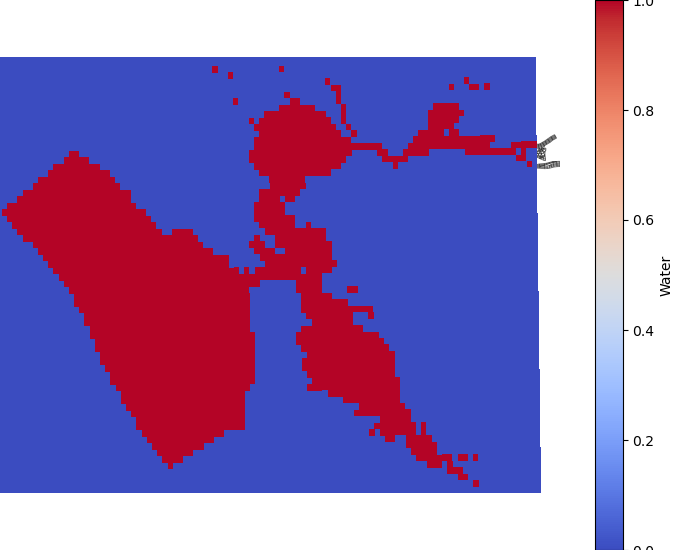

In [76]:
# Get a watermask from the grid. Will ignore data farther offshore, 
# even though there could be some information out there relevant
# to the coastal points

temp_utils.add_watermask(ds,grid)

fig,ax=plt.subplots(figsize=(7.0,5.5))
coll=pad_pcolormesh( ds.x, ds.y, ds.water, cmap='coolwarm',zorder=2, ax=ax)
grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.6,zorder=0)
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
plt.colorbar(coll,label='Water')

In [77]:
# test round trip of water indexing:
def wet_recon(wet_data):
    d=np.full( (ds.dims['latitude'], ds.dims['longitude']), np.nan)
    d[ds.water] = wet_data
    return d
    
if 0:
    data=ds.sst.isel(time=35)
    wet_data=data.values[ds.water.values]
    
    # using numpy broadcasting:
    dA=wet_recon(wet_data)
    
    # manual:
    dB=np.full( (ds.dims['latitude'], ds.dims['longitude']), np.nan)
    for ll in np.ndindex( ds.water.shape ):
        wet_index=ds.water_index.values[ll[0],ll[1]]
        dB[ll[0],ll[1]] = wet_data[wet_index]
    
    assert np.allclose(dA,dB,equal_nan=True)

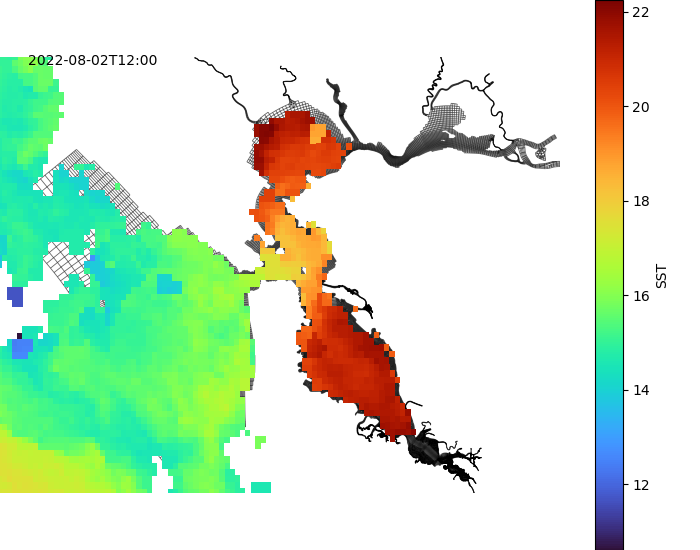

In [78]:
fig,ax=plt.subplots(figsize=(7.0,5.5))

# tidx=31, 8/2 is great.
tidx=31
coll=pad_pcolormesh( ds.x, ds.y, ds.sst.isel(time=tidx), cmap='turbo',zorder=2,ax=ax)

grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.6,zorder=0)
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
plt.colorbar(coll,label='SST')
ax.text(0.05, 0.98,str(ds.time.values[tidx])[:16],transform=ax.transAxes) ;

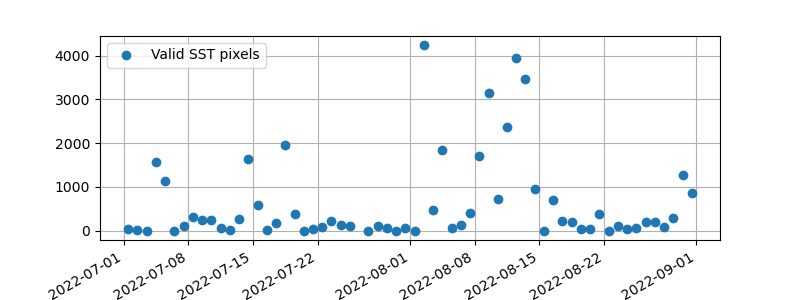

In [79]:
fig,ax=plt.subplots(figsize=(8,3))
ax.plot( ds.time, ds.sst.notnull().sum(dim=['latitude','longitude']), label='Valid SST pixels',marker='o',lw=0)
ax.legend(loc='upper left')
fig.autofmt_xdate()
ax.grid()

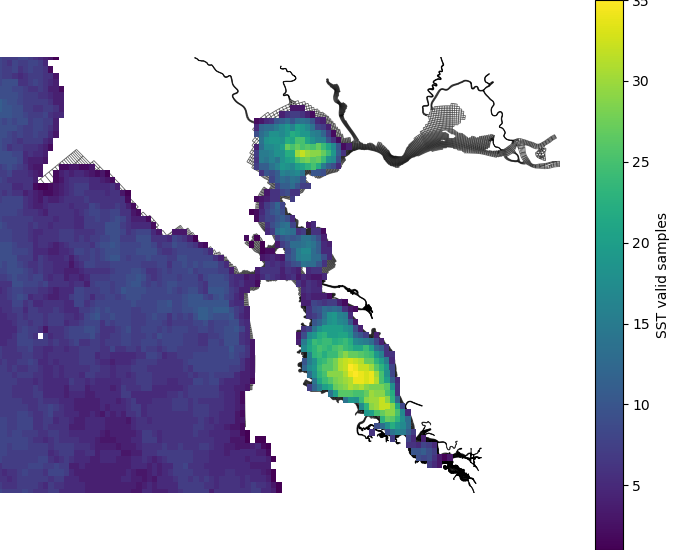

In [80]:
# Samples per pixel
fig,ax=plt.subplots(figsize=(7.0,5.5))

counts=ds.sst.notnull().sum(dim='time').values.astype(np.float64)
counts[ counts==0]= np.nan

coll=pad_pcolormesh( ds.x, ds.y, counts,zorder=2,ax=ax)

grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.6,zorder=0)
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
plt.colorbar(coll,label='SST valid samples') ;

In [81]:
# What's a reasonable way to fill?
# Some combination of 
#  * temporal autocorrelation
#  * generic (distance-based) spatial autocorrelation
#  * specific (covariance-based) spatial autocorrelation -- gets expensive.

# Can operate on the whole stack

In [82]:
# ~2000 water pixels.
# precomputed covariance matrix will take 4M entries. Storage is no
# problem, but naive computation is.

def compute_pixel_correlation(ds,rho=0.9974):
    Nwater = ds.water.values.sum()
    adj = sparse.dok_matrix( (Nwater,Nwater), dtype=np.float64)
    
    water=ds.water.values
    water_ll_idx = ds.water_ll_idx.values # linear => row,col
    water_idx = ds.water_index.values # row,col => linear
    
    # adj_decorr=0.1 # 0.05 is the "empirical" choice, but feels too small
    # calculating the correlation between adjacent pixels, get ~ rho=0.997
    # To chain that, I want negative log.
    adj_nlog_corr=-np.log(rho) 
    
    for wetA in range(Nwater):
        A_ll=water_ll_idx[wetA]
    
        for nbr in [[0,1], [1,0], [1,1], [1,-1]]: # east, north, northeast, southeast
            Blat=A_ll[0]+nbr[0]
            Blon=A_ll[1]+nbr[1]
            if Blat < 0 or Blon < 0: continue
            if Blat >= water.shape[0] or Blon>=water.shape[1]: continue 
            if not water[Blat, Blon]: continue
            wetB=water_idx[Blat, Blon]
            fac=np.sqrt(nbr[0]**2+nbr[1]**2)
            adj[wetA,wetB]=fac*adj_nlog_corr
            adj[wetB,wetA]=fac*adj_nlog_corr
    
    adj_csr=adj.tocsr()
    wet_nlog_corr=sparse.csgraph.floyd_warshall(adj_csr) # 5 seconds
    wet_corr=np.exp(-wet_nlog_corr)
    return wet_corr
    
wet_corr=compute_pixel_correlation(ds)

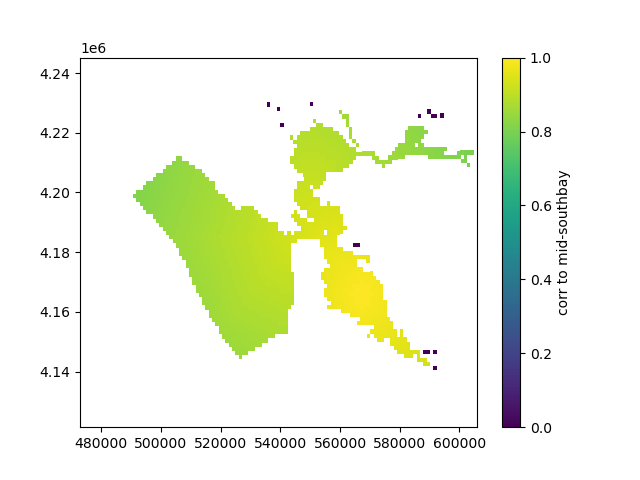

In [83]:
if 1: # Confirm that worked
    # Choose a pixel in the middle-ish.
    water_idx = ds.water_index.values 
    origin=[27,85] 
    origin_idx=water_idx[ tuple(origin) ]
    ll_dists=wet_recon(wet_corr[origin_idx,:])
    fig,ax = plt.subplots()
    coll=pad_pcolormesh( ds.x, ds.y, ll_dists,zorder=2,ax=ax)
    ax.axis('equal')
    plt.colorbar(coll,label='corr to mid-southbay')

In [86]:
def combine_covariance(mu,v,origin,covariates,plot=False,var_obs=0.1):
    """
    mu,v:  priors, used as the background field and error variance.
    origin: wet index of the origin
    covariates: [ (var, wet_index, value), ... ]
    """
    # The original approach estimated a decorrelation for each covariate.
    # Use the corresponding values from the correlation matrix instead, so
    # they are consistent with covariance between covariates.
    all_idxs = [ origin ] + list( covariates[:,1].astype(int))
    
    #water=ds.water.values
    #water_ll_idx = ds.water_ll_idx.values # linear => row,col
    #water_idx = ds.water_index.values # row,col => linear
    
    #origin_idx=water_idx[origin[0],origin[1]]
    #cov_idxs= [ water_idx[int(entry[1]), int(entry[2])] for entry in covariates]
    # all_idxs= np.r_[origin_idx,cov_idxs]
    
    all_corr=wet_corr[all_idxs,:][:,all_idxs]
    
    # https://www.atmosp.physics.utoronto.ca/PHY2509/ch3.pdf
    
    # mu,v, the priors, are taken as the "background" field in OI terms.
    # This could be expanded at some point to account for long-term mean temp
    # or a proper model output. For present purposes, I just want it to be a
    # spatially uniform, fairly uninformative prior.
    
    background_mu =np.full( len(all_corr), mu)
    
    # error covariance for the background field.
    Pb = v * all_corr
    
    # error covariance for observations. Assume no correlation, so just the error variance for each.
    # First entry we have no data, so either v, or something else really large.
    obs_variance = np.r_[100*v,var_obs*np.ones(len(covariates))]
    R=np.diag(obs_variance)

    R_Pb_inv = np.linalg.inv(R + Pb)
    W = Pb @ R_Pb_inv
    
    # For the present use case the math could be streamlined, since I don't
    # have a real background field or an observation at the origin.
    # but it doesn't really hurt, and keeps the method intact for future use.
    
    if plot:
        fig,ax=plt.subplots()
        #img=plt.imshow(W,origin='upper')
        #plt.colorbar(img,label='W')
        labels=[ f"({r},{c})" for r,c in all_coords]
        sns.heatmap(W,annot=True, xticklabels=labels, yticklabels=labels) ;
    
    observations=np.r_[mu, covariates[:,2]]
    
    results = background_mu + W@(observations - background_mu)
    result=results[0]

    # still need a variance estimate!
    # This is from the first section of the PDF
    Pa = R@R_Pb_inv@Pb

    # The OI section introduces an observation projection H. If I take that to be
    # the identity, can use their simpler expression for Pa, get same value.
    # Pa = (np.eye(len(all_corr))-W)@Pb
    return result,Pa[0,0]


if 0:# Testing around the middle of south bay:
    # OUTDATED - row,col is now just wet index.
    covariates=np.array(
        [ [ 0.9       , 23.        , 91.        , 20.61000061], # farther southeast
          [ 0.9       , 26.        , 86.        , 23.30999947], # south-southwest
          [ 1.        , 28.        , 84.        , 23.30999947], # northwest
        ])
    plot=True
    
    combine_covariance(mu=15,v=10.0**2,origin=[27,85],covariates=covariates,plot=True)
    
    # Sort of surprised that Pa[0,0] is not smaller. 

In [92]:
# Start with just the space component:
# decorrelation in space, for now assuming global mean, scales are all the same.
# so we can deal directly with variance.
# Break it down to figuring out one pixel at one time

def spatial_autocorr(wet_tgt_idx,wet_observations,max_steps=60,max_covariates=80,var_obs=0.1):
    """
    covariance is deduced from wet_corr
    combine:
      'simple': assume correlates are independent. 
      'covariance' account for covariance.
    """
    # Initial approach:
    # Breadth-first search for cells with valid values, out to some threshold of variance.

    # Then use what is essentially weighted least-squares to estimate a value and variance based
    # on the covariates with known data. In the initial approach this is done iteratively, updating
    # mu,sigma^2 with one covariate at at ime. That inherently assumes that covariates are independent,
    # which is a bad assumption.
    # The variances that come out of this are unfortunately underestimates, given that there is a lot of
    # correlation between the covariates.
    
    # For example, point A might decorrelate from B by 1 degC^2, and from C by 1 degC^2.
    # If B and C are actually perfectly correlated, then the information from C does not actually
    # improve our estimate of A.

    # First refinement: use the same set of correlates, but account for covariance when combining.

    # use the correlation matrix to grab good candidates
    wet_data_idxs = np.nonzero(np.isfinite(wet_observations))[0] # wet indices with data.
    
    correlations=wet_corr[wet_tgt_idx,wet_data_idxs] # correlation coefficient between target pixel and valid wet pixels.
    sources = wet_data_idxs[ np.argsort(-correlations) ] 
    sources=sources[:max_covariates] # may not be necessary

    covariates=[]
    for source in sources: 
        # new code ignores the 'var' argument. Will put correlation in while debugging.
        covariates.append( [wet_corr[wet_tgt_idx,source],source, wet_observations[source]])

    covariates = np.array(covariates)
    
    # "prior"
    mu=15.
    v=(10.0)**2

    if len(covariates)>0:
        mu,v = combine_covariance(mu,v,origin=wet_tgt_idx,covariates=covariates,plot=False,
                                  var_obs=var_obs)
    return mu,v

def spatial_extrap(observed,var_obs=0.1):
    """
    Extrapolate in space by simplified optimal interpolation.
    Each pixel is handled separately, and with a limited number of observations.
    In some cases this can lead to discontinuities, where one pixel has neighbors
    in multiple directions, but an adjacent pixel has all of its neighbors
    in only one direction.
    Increasing the max_covariates helps, but not a guarantee.
    """
    est_mean=observed.copy()
    est_var =np.zeros(est_mean.shape)
    water=ds.water.values

    water_index=ds.water_index.values
    wet_observed=observed[ds.water.values] # ravel'd observations of wet pixels

    for row,col in utils.progress(np.ndindex(est_mean.shape)):
        if not water[row,col]:
            est_mean[row,col]=np.nan
            est_var[row,col]=np.nan
        elif np.isfinite(est_mean[row,col]):
            est_var[row,col] = var_obs
        else:
            mu,v=spatial_autocorr(water_index[row,col],wet_observed,var_obs=var_obs)
            est_mean[row,col]=mu
            est_var[row,col]=v
    return est_mean,est_var


In [93]:
# Show interpolation results:
sst=ds.sst.values
observed=sst[31,:,:]

In [94]:
est_mean,est_var = spatial_extrap(observed)

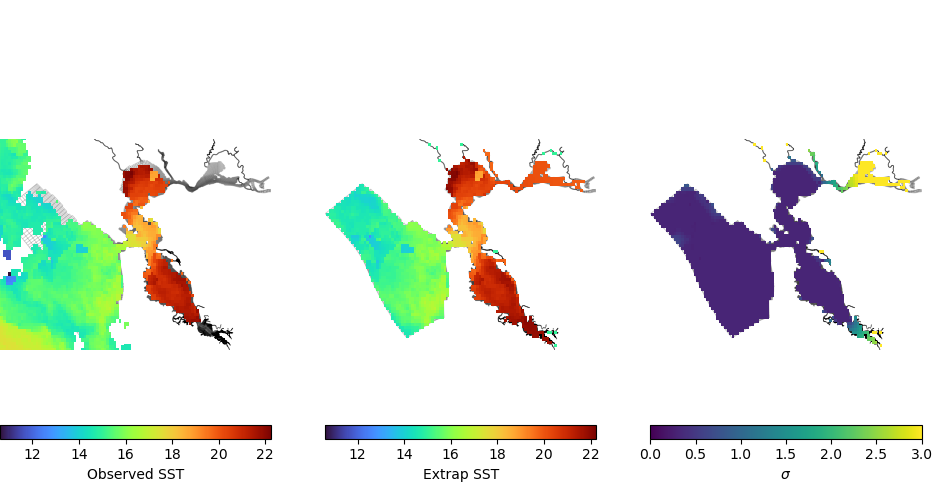

In [95]:
fig,axs=plt.subplots(1,3,figsize=(9.5,5.0))

coll0=pad_pcolormesh( ds.x, ds.y, observed, cmap='turbo',zorder=2,ax=axs[0])
coll1=pad_pcolormesh( ds.x, ds.y, est_mean, cmap='turbo',zorder=2,ax=axs[1])
coll2=pad_pcolormesh( ds.x, ds.y, np.sqrt(est_var), zorder=2,ax=axs[2])

plt.colorbar(coll0,label='Observed SST',ax=axs[0],orientation='horizontal')
plt.colorbar(coll1,label='Extrap SST',ax=axs[1],orientation='horizontal')
plt.colorbar(coll2,label='$\\sigma$',ax=axs[2],orientation='horizontal')

coll2.set_clim([0,3.0])
coll1.set_clim(coll0.get_clim())

for ax in axs:
    grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.2,zorder=1)
    ax.axis('off')
    
fig.subplots_adjust(left=0,right=0.97,top=1,bottom=0)

In [96]:
# Stack those up
est_means=np.zeros_like(sst)
est_vars=np.zeros_like(sst)

for tidx in utils.progress(range(sst.shape[0])):
    observed=sst[tidx,:,:]
    est_mean,est_var = spatial_extrap(observed)
    est_means[tidx,:,:] = est_mean
    est_vars[ tidx,:,:] = est_var


INFO:utils:7/61
INFO:utils:10/61
INFO:utils:14/61
INFO:utils:18/61
INFO:utils:23/61
INFO:utils:27/61
INFO:utils:34/61
INFO:utils:38/61
INFO:utils:42/61
INFO:utils:46/61
INFO:utils:50/61
INFO:utils:55/61
INFO:utils:58/61


In [97]:
ds['extrap_spatial_mu']= ds.sst.dims, est_means
ds['extrap_spatial_var']=ds.sst.dims, est_vars

In [98]:
corr_temporal=0.9157

def combine_temporal_covariance(mus,variances, corr_temporal=0.9157, plot=False):
    """
    Similar to combine_covariance, but more generic, and operates on
    1D data.
    """
    background_mu=15.0 # or maybe some sort of global mean
    background_var = 10**2 # not really sure what this ought to be.
    
    observations=mus
    obs_variance = variances
    
    N=len(mus)
    
    rows,cols=np.meshgrid(np.arange(N),np.arange(N))
    time_offset=np.abs(rows-cols)
    
    all_corr=corr_temporal**time_offset
    
    background_mus = np.full( N, background_mu)
    
    # error covariance for the background field.
    Pb = background_var * all_corr
    
    R=np.diag(obs_variance)
    
    R_Pb_inv = np.linalg.inv(R + Pb)
    W = Pb @ R_Pb_inv
    
    results = background_mus + W@(observations - background_mus)
    
    # still need a variance estimate!
    # This is from the first section of the PDF
    Pa = R@R_Pb_inv@Pb
    
    result_vars=np.diag(Pa)
    
    if plot:
        fig,ax=plt.subplots()
        #labels=[str(i) for i in range(N)]
        #sns.heatmap(W,annot=True, xticklabels=labels, yticklabels=labels) ;
        t=np.arange(N)
        ax.errorbar( t, mus, yerr=np.sqrt(variances), label='From spatial')
        ax.errorbar( t, results, yerr=np.sqrt(result_vars), label='Analysis')
        ax.legend( loc='upper right')
    
    return results,result_vars

def extrap_time_space_covariance(tidx,corr_temporal=0.9157,water=ds.water.values):
    """
    OI-esque extrapolation in time
    """
    est_mean_time_space = np.zeros(sst.shape[1:],np.float64)
    est_var_time_space  = np.zeros(sst.shape[1:],np.float64)
    for row,col in utils.progress(np.ndindex(sst[tidx].shape)):
        if not water[row,col]:
            mu=np.nan
            v=np.nan
        else:
            analysis_mu, analysis_vars=combine_temporal_covariance(est_means[:,row,col],
                                                                   est_vars[:,row,col],
                                                                   corr_temporal=corr_temporal)
            mu=analysis_mu[tidx]
            v=analysis_vars[tidx]
        est_mean_time_space[row,col]=mu
        est_var_time_space[row,col] =v
    return est_mean_time_space,est_var_time_space

In [101]:
# Render all times to ds, save out, ready for putting on grid and final filling.
est_means_time_space=np.zeros_like(sst)
est_vars_time_space =np.zeros_like(sst)

water=ds.water.values
corr_temporal=0.9157

for row,col in utils.progress(np.ndindex(sst.shape[1:])):
    if not water[row,col]:
        mus=np.nan
        vars=np.nan
    else:
        mus,vars = combine_temporal_covariance(est_means[:,row,col],
                                                               est_vars[:,row,col],
                                                               corr_temporal=corr_temporal)
    est_means_time_space[:,row,col]=mus
    est_vars_time_space[:,row,col] =vars


In [104]:
ds['extrap_spatiotemporal_mu']=ds.sst.dims, est_means_time_space
ds['extrap_spatiotemporal_var']=ds.sst.dims, est_vars_time_space


In [106]:
ds.to_netcdf("extrapolated_avhrr.nc")

In [107]:
ds

<xarray.Dataset>
Dimensions:                    (latitude: 80, longitude: 120, time: 61,
                                wet: 2001, two: 2)
Coordinates:
    altitude                   float64 0.0
  * latitude                   (latitude) float64 37.3 37.31 ... 38.28 38.29
  * longitude                  (longitude) float64 236.7 236.7 ... 238.2 238.2
  * time                       (time) datetime64[ns] 2022-07-01T12:00:00 ... ...
    x                          (latitude, longitude) float64 4.734e+05 ... 6....
    y                          (latitude, longitude) float64 4.128e+06 ... 4....
Dimensions without coordinates: wet, two
Data variables:
    sst                        (time, latitude, longitude) float32 nan ... nan
    water                      (latitude, longitude) bool False False ... False
    water_index                (latitude, longitude) int64 -1 -1 -1 ... -1 -1 -1
    water_ll_idx               (wet, two) int64 9 107 10 104 10 ... 73 57 73 70
    extrap_spatial_mu          (time, latitude, longitude) float32 nan ... nan
    extrap_spatial_var         (time, latitude, longitude) float32 nan ... nan
    extrap_spatiotemporal_mu   (time, latitude, longitude) float32 nan ... nan
    extrap_spatiotemporal_var  (time, latitude, longitude) float32 nan ... nan
Attributes: (12/56)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Grid
    composite:                     true
    contributor_name:              NOAA NWS Monterey and NOAA CoastWatch
    contributor_role:              Source of level 2 data.
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    ...                            ...
    testOutOfDate:                 now-3days
    time_coverage_end:             2022-09-26T12:00:00Z
    time_coverage_start:           2022-09-26T12:00:00Z
    title:                         SST, NOAA POES AVHRR, LAC, 0.0125 degrees,...
    Westernmost_Easting:           215.0
    NCO:                           netCDF Operators version 4.9.0 (Homepage =...

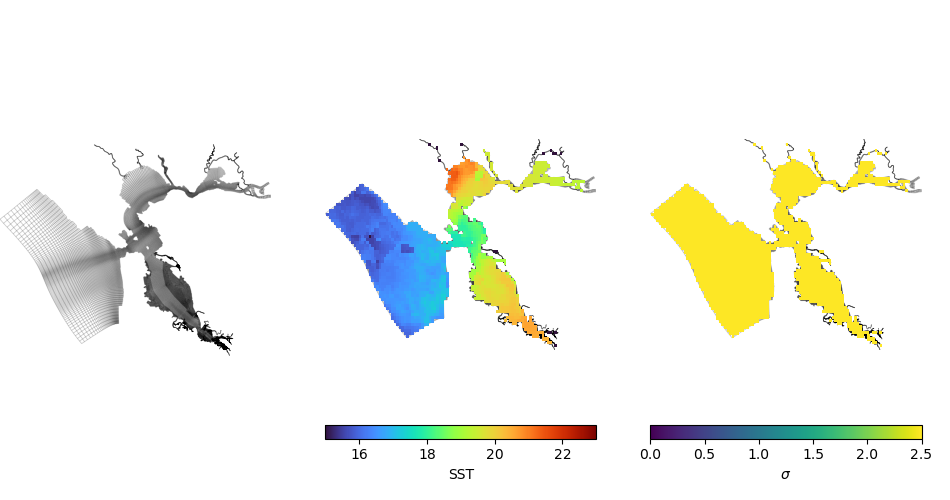

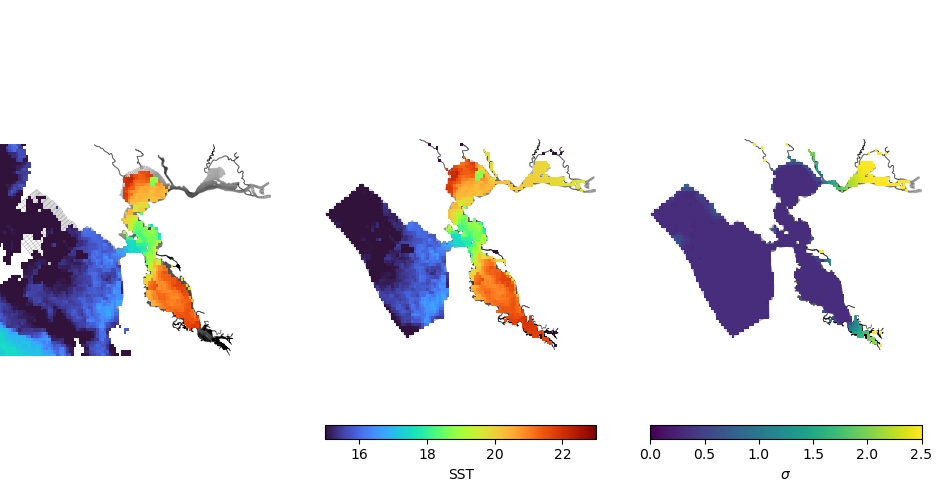

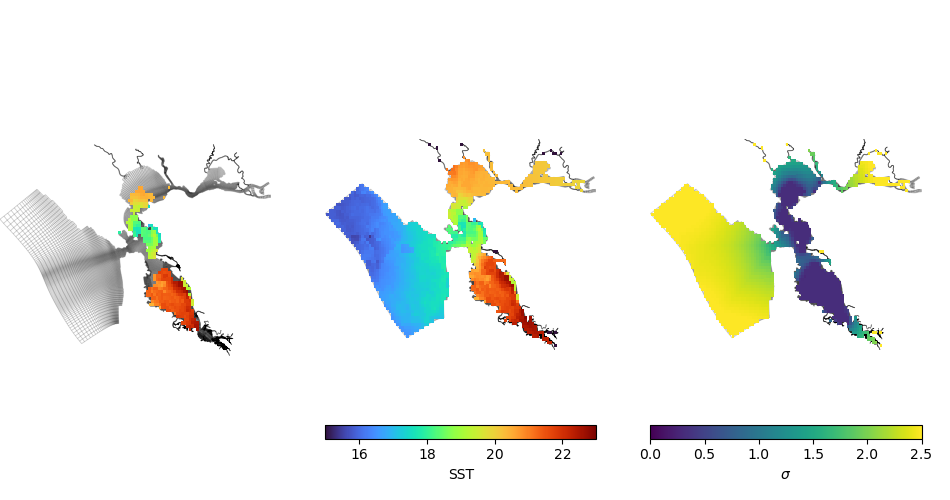

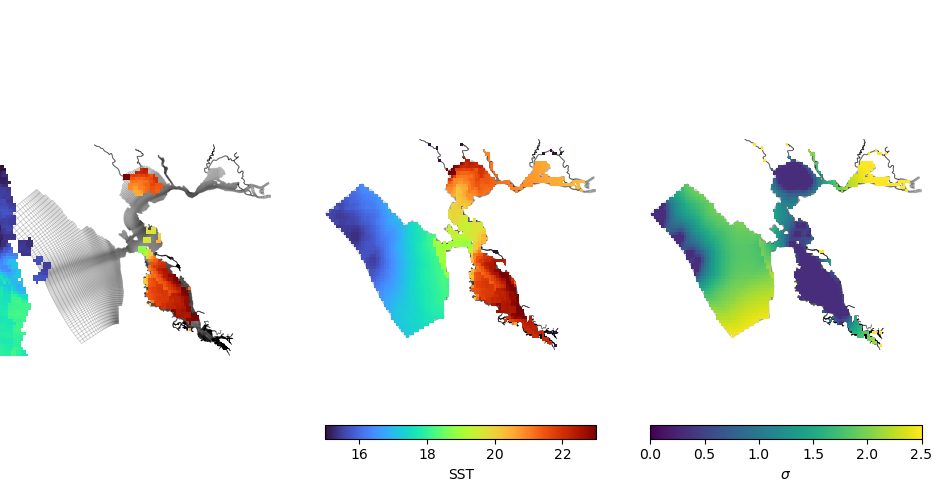

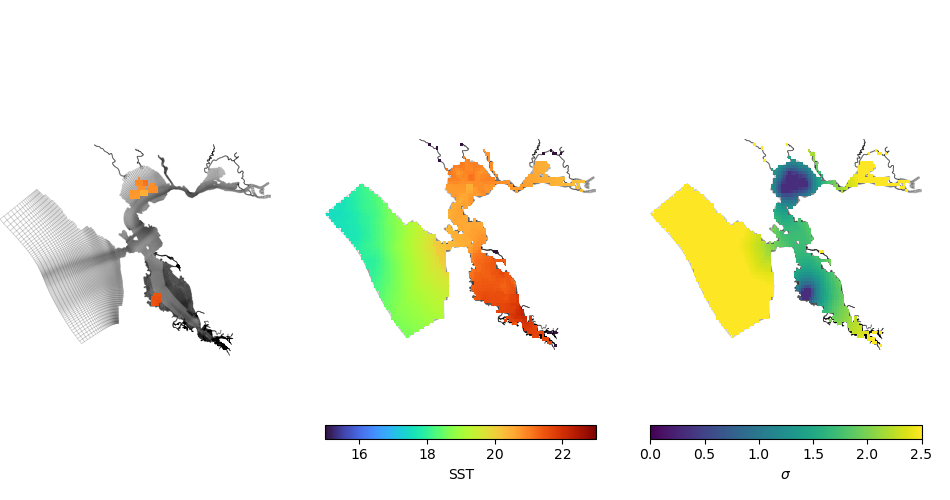

In [105]:

for tidx in range(30,35):
    #est_mean_time_space,est_var_time_space = extrap_time_space(tidx,dec_temporal=0.5)
    #est_mean_time_space,est_var_time_space = extrap_time_space_covariance(tidx)

    est_mean_time_space = est_means_time_space[tidx,:,:]
    est_var_time_space  = est_vars_time_space[tidx,:,:]
    
    # Show interpolation results:
    fig,axs=plt.subplots(1,3,figsize=(9.5,5.0))
    
    coll0=pad_pcolormesh( ds.x, ds.y, sst[tidx], cmap='turbo',zorder=2,ax=axs[0])
    coll1=pad_pcolormesh( ds.x, ds.y, est_mean_time_space, cmap='turbo',zorder=2,ax=axs[1])
    coll2=pad_pcolormesh( ds.x, ds.y, np.sqrt(est_var_time_space), zorder=2,ax=axs[2])
    
    coll0.set_clim([15,23])
    coll1.set_clim(coll0.get_clim())
    
    plt.colorbar(coll1,label='SST',ax=axs[1],orientation='horizontal')
    plt.colorbar(coll2,label='$\\sigma$',ax=axs[2],orientation='horizontal')
    
    coll2.set_clim([0,2.5])
    
    for ax in axs:
        grid.plot_edges(ax=ax,color='k',lw=0.6,alpha=0.2,zorder=1)
        ax.axis('off')
        
    fig.subplots_adjust(left=0,right=0.97,top=1,bottom=0)


In [ ]:
# What's a reasonable spatial decorrelation?
a_samples=np.concatenate( [ sst[:,:-1,:].ravel(), # row to row 
                            sst[:,:,:-1].ravel(), # col to col
          ])

b_samples=np.concatenate( [ sst[:,1:,:].ravel(), # row to row 
                            sst[:,:,1:].ravel(), # col to col
          ])

valid = np.isfinite(a_samples + b_samples)

sigma = np.sqrt( np.mean(((a_samples[valid] - b_samples[valid])**2) ) )
sigma**2

In [ ]:
# for the optimal interpolation approach, get this as a correlation coefficient:
rho=np.corrcoef(a_samples[valid],b_samples[valid])[0,1] # 0.997
rho

In [ ]:
# And temporal decorrelation?
a_samples=sst[:-1,:,:].ravel()
b_samples=sst[ 1:,:,:].ravel()

valid = np.isfinite(a_samples + b_samples)

sigma = np.sqrt( np.mean(((a_samples[valid] - b_samples[valid])**2) ) )
sigma**2

In [ ]:
# Likewise, get this as a correlation coefficient
np.corrcoef(a_samples[valid],b_samples[valid])[0,1]

In [ ]:
# Somewhere I had some notes on interpolating one value based on its correlation with
# a bunch of other values, including covariance among those other values.
# https://www.atmosp.physics.utoronto.ca/PHY2509/ch3.pdf
# That's not what I was using, but the gist is pretty close. Specifically, that document
# goes into the math of how 2 independent observations are more informative than two
# correlated observations.